In this notebook, we run the Metropolis-Hastings algorithm on parameters in the Logistic Equation.For the grid approximation, applied to the same model, see https://github.com/thomasarmstrong98/thirdyearproj/blob/master/logistic_two_param_grid.ipynb.

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
from scipy.stats import norm
import scipy.stats
import mpl_toolkits
from matplotlib import cm
import statsmodels.stats.api as sms

from IPython.display import HTML

from google.colab import files

plt.rc('text', usetex=False)
plt.rc('font', family='serif')


## ODE Model
Suppose we are given some experimental for a system which we believe follows a Logisitic/Verhust-Pearl differential equation. We do not know the values growth rate $r$ or the carrying capacity of the system $K$. We wish to estimate these parameters whilst still incorporating our prior knowledge about what values $r$ and $K$ may take.

The ODE model for the system we are considering is:

$$ \frac{dN}{dt} = r \: N(1-\frac{N}{K}) $$

This equation has a closed solution which can be written as :
$$ N(t) = \frac{Ce^{r t}}{1 + \frac{C}{K}e^{r t}}, \quad \text{where} \; \:C=\frac{KN(0)}{K-N(0)}.$$
In this setting we will behave as if the initial condition $N(0)$ is known and is therefore not a parameter to consider. This allows us to compute the unique solution to this ODE at any time $t$ given parameters $r$ and $K$.



## Priors and Likelihood

#### Prior

We wish to specify pior distributions for the parameters $r$ and $K$. Here, they are a priori independent; our prior for $r$ follows an Inverse-Gamma whilst $K$ follows a normal distribution.


$$ r \sim \text{Inv-Gamma}(a, \sigma_0) \quad \text{and} \quad K \sim \mathcal{N} ( \mu_1, \sigma_1^2) $$

#### Likelihood


We will generate some random experimental data of m observations, $\mathbf{y} = (y_1, y_2, \ldots, y_m)$ below. We assume that this data takes the value of the solution of our ODE but has been disrupted by independent zero-mean Gaussian noise with a known varance $\tau^2$. That is,

$$ y_i = N(t_i) + \epsilon_i, \quad \text{where }  \epsilon_i, ..., \epsilon_m \sim  \mathcal{N} ( 0 , \tau^2) $$

Which also implies:

$$ y_i \sim \mathcal{N}(N(t_i), \tau^2) $$

Therefore, conditional on the parameters $r$ and $K$ we have the likelihood function:

$$ y_i \mid r, K \sim \mathcal{N}(N(t_i; r, K), \tau^2) $$
where $N(t_i; r, K)$ denotes the solution obtained from our ODE as described in the previous section, having inputted specific parameter values of $r$ and $K$.


In [0]:
#Defining the initial conditions and true parameter values

np.random.seed(2018)

r = 1.2
K = 4.6
initial_N = 0.1

def initial_cond(initial_N, K):
    return (K*initial_N) / (K - initial_N) 

#The solution of our ODE system

def diff_eqn_soln(r, K, initial_N, t):
    C = initial_cond(initial_N, K)
    return C*np.exp(r*t)/(1 + (C/K)*np.exp(r*t))

In [0]:
#Genertating the true solution of the system

t = np.linspace(0,20, 51)
sol_df = pd.DataFrame(index = t)
sol_df['N'] = diff_eqn_soln(r, K, initial_N, t)

In [0]:
#Corrupting our solution with Gaussian Noise

sd = 0.3

sim_df = pd.DataFrame(index = t)
experiment = [sol + scipy.stats.norm.rvs(0, sd) for sol in sol_df['N']]
sim_df['N'] = experiment

In [5]:
sim_df.head()

,N
0.0,0.016970
0.4,0.334027
0.8,0.896849
1.2,0.010606
1.6,0.756160


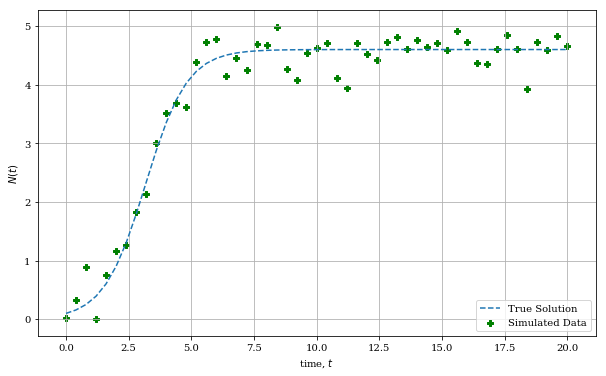

In [6]:
fig_size = plt.rcParams["figure.figsize"]

fig_size[0] = 10
fig_size[1] = 6

plt.plot(sol_df['N'], '--')
plt.scatter(t, sim_df['N'], color = 'g', marker = 'P')
plt.grid(True)
plt.xlabel("time, $t$")
plt.ylabel("$N(t)$")
plt.legend(["True Solution", "Simulated Data"], loc = 'lower right')
plt.show()

In [0]:
# files.download('logistic_data_graph.pdf')

## Likelihood

$$ p(r, K \mid \mathbf{y}) = \frac{p(\mathbf{y} \mid K, r) p(K, r)}{p(\mathbf{y})} =  \frac{p(\mathbf{y} \mid K, r) p(K) p(r)}{p(\mathbf{y})}$$


Our likelihood model assumes conditional independence between observations, this implies that we can treat our data as exchangeable. 

$$p(\boldsymbol{y} \mid r, K) = \prod_{i=1}^m p(\boldsymbol{y_i} \mid r, K)$$

To improve our numerical stability, we will instead consider the log likelihood, before exponentiating:
$$
    \log(p(\boldsymbol{y} \mid \boldsymbol{\theta})) = \sum_{i=1}^m \log(\mathcal{N}( \boldsymbol{y_i} \mid N(t_i; r, K), \tau^2)).
$$

Since we are considering the ratio of posterior denisties in the Metropolis-Hastings algorithm, we only have to calculate the unnormalised posterior density:

$$p^*(r, K \mid \boldsymbol{y}) = p(r, K)\, p(\boldsymbol{y} \mid r, K) $$

## Posterior via MCMC (Metropolis Hastings)

Below I will briefly describe the MH algorithm that will be implemented. 



Suppose we have a state $X^{(t)} = (K^{(t)}, r^{(t)})$ then we generate a new sample using a proposal distribution $q$.


Generate $Y^{(t)} \sim q(y \mid x^{(t)})$,

Move to the new position $X^{(t+1)}$, where:
\begin{equation}
  X^{(t+1)}=\begin{cases}
    Y^{(t)} \: \text{with probability} \:\alpha(x^{(t)}, Y^{(t)}).\\
    x^{(t)} \: \text{with probability} \:  1-\alpha(x^{(t)}, Y^{(t)}).
  \end{cases}
\end{equation}

Where 

\begin{equation}
\alpha(x^{(t)}, Y^{(t)}) = \min\left\{ 1, \frac{p(Y^{(t)} \mid \mathbf{y})q(Y^{(t)} \mid X^{(t)})}{p(X^{(t)} \mid \mathbf{y})q(X^{(t)} \mid Y^{(t)})} \right\} 
\end{equation}

For a Guassian proposal distribution, the $q(\cdot \mid \cdot)$ terms in the calculation of $\alpha$ disappear because of the symmetry of the distribution. 

In this example we will define our proposal distribution by a Guassian with mean of the current state and a diagonal covariance matrix $\Sigma$, that is:

$$ Y^{(t)} \sim N(x^{(t)}, \Sigma) $$

As described in my report, we will be updating this$ \Sigma$ if the acceptance ratio of the chain falls out of certain bounds.

In [0]:
import math

# Defining the log likelihood, the joint prior and the unnormalised posterior density.

def log_normal_pdf(x, mu, sigma):
    return -0.5*math.log(2*math.pi) - math.log(sigma) - (1/(2*sigma**2))*(x - mu)**2


def log_likelihood(theta, sim_df):
    r = theta[0]
    K = theta[1]
    initial_N = 0.1
    lik_sum = 0
    for index, obs in sim_df.iterrows():
        lik_sum = lik_sum + log_normal_pdf(sim_df['N'].loc[index], diff_eqn_soln(r, K, initial_N, index), sd)
    return lik_sum


def prior(theta):
    r = theta[0]
    K = theta[1]
    return scipy.stats.norm.pdf(K, 5, 2)*scipy.stats.invgamma.pdf(r,a =1, loc = 0, scale = 2)
        
    
def posterior(theta, sim_df):
    return prior(theta)*math.exp(log_likelihood(theta, sim_df))

In [0]:
# Proposal Distribution


def q_dist(x_t, C):
    # Gaussian proposal
    return np.random.multivariate_normal(x_t, C)


def test_for_cov_estimation(acceptance_log):
    # If the acceptance ratio falls below 0.15 or above 0.35, we will re-estimate the covaraiance matrix.
    # returns True if must be re-estimated 
    ratio = sum(acceptance_log) / len(acceptance_log)
    if ratio < 0.15:
        return True, ratio
    elif ratio > 0.35:
        return True, ratio
    else: 
        return False, ratio
    
    
def estimate_var(samples):
    # Estimates the variance entry for one parameter
    samp_mean = np.mean(samples)
    var_estimate = 0
    for entry in samples:
        var_estimate = var_estimate + (entry - samp_mean)**2
    var_estimate = (1/(len(samples)-1))*var_estimate
    return var_estimate


def within(df_of_samples):
    """
    Calculates within-chain variance.
    """
    s = []
    for col in list(df_of_samples):
        s.append(np.var(df_of_samples[col]))
    W = np.mean(s)
    return W


def between(df_of_samples):
    """
    Calculates between-chain variance.
    """
    mu = []
    for col in list(df_of_samples):
        mu.append(np.mean(df_of_samples[col]))
    mu_overall = np.mean(mu)
    m = len(list(df_of_samples))
    n = len(df_of_samples[0])
    B = (n/(m- 1.0)) * np.sum((mu - mu_overall)**2)
    return B


def R_hat(samples):
    """
    Calculates r-hat = sqrt(((n - 1)/n * W + (1/n) * B)/W) as per "Bayesian
    data analysis", 3rd edition, Gelman et al., 2014.
    """
    W = within(samples)
    B = between(samples)
    n = len(samples[0])
    return np.sqrt((W + (1.0 / n) * (B - W)) / W)

In [0]:
# Initial cov guess

C = np.array([[0.1, 0], 
              [0, 0.5]])

In [0]:
def mh_algorithm(theta_0, n, m, q_dist):
    """
    Metropolis-Hastings algorithm, based on Information Theory, Inference, and
    Learning Algorithms, MacKay 2003.
    
    ------------------------------------------------------------------------
    
    Inputs
    
    theta_0 - set of starting starting for chains, must be length m
    n - duration to run the chain before checking R hat diagnostic
    m - number of chains
    q_dist - proposal distribution
    
    ------------------------------------------------------------------------
    
    Returns
    
    set_of_trace - dictionary of the m chains
    acceptance_hist - df of the history of proposed state acceptance
    ratio_hist - df of the acceptance ratio
    
    
    """
    d = len(theta_0[0])
    iter_loop = 0
    acceptance_hist = []
    ratio_hist = []
    set_of_trace = {}
    C =  np.array([[0.1, 0], 
                   [0, 0.5]])
    for i in range(m):
        trace = pd.DataFrame(columns = ["r", "K"])
        trace = trace.append(pd.DataFrame([[theta_0[i][0],theta_0[i][1]]], columns = ["r", "K"]))
        loop_num = 1
        theta = theta_0[i]
        while loop_num < n:
            # Propose new step
            y = q_dist(theta, C)
            p_x = posterior(theta, sim_df)
            p_y = posterior(y, sim_df)
            alpha = min(p_y / p_x, 1)
            # Generate random number to decide if we accept proposal
            rand = np.random.uniform(0,1)
            if rand > 1- alpha:
                theta_new = y
                acceptance_hist.append(1)
            else:
                theta_new = theta
                acceptance_hist.append(0)
            theta = theta_new
            
            trace = trace.append(pd.DataFrame([[theta[0],theta[1]]], columns = ["r", "K"]))

            # Every 100 iterations, re-calculate acceptance ratio
            if loop_num % 100 == 0:
                recal, ratio = test_for_cov_estimation(acceptance_hist)
                if recal:
                    C = np.array([[(2.4/math.sqrt(d))*estimate_var(trace['r']),                        0], 
                                  [0                       , (2.4/math.sqrt(d))*estimate_var(trace['K'])]])
                else: 
                    pass
                ratio_hist.append(ratio)
                
            loop_num = loop_num + 1
        trace = trace.reset_index()
        trace = trace.drop(["index"], axis=1)
        set_of_trace[i] = trace
    # Calculate and print R hat
    k_set_of_trace = {}
    r_set_of_trace = {}
    for i in range(len(set_of_trace)):
        k_set_of_trace[i] = set_of_trace[i]['K']
        r_set_of_trace[i] = set_of_trace[i]['r']
    r_hat_k = R_hat(k_set_of_trace)
    r_hat_r = R_hat(r_set_of_trace)
    print("----------------------------------")
    print("R hat statistic for r :" + str(r_hat_r))
    print("R hat statistic for K :" + str(r_hat_k))
    print("----------------------------------")
    return set_of_trace, pd.DataFrame(acceptance_hist), pd.DataFrame(ratio_hist)

## Running our MCMC method

In [0]:
# Generating the starting points for the M-H algorithm

theta_0 = [[scipy.stats.invgamma.rvs(a = 1, loc= 0, scale = 2, random_state = 501), scipy.stats.norm.rvs(5, 2, random_state = 511)], [scipy.stats.invgamma.rvs(a = 1, loc= 0, scale = 2, random_state = 502), scipy.stats.norm.rvs(5, 2, random_state = 512)],
           [scipy.stats.invgamma.rvs(a = 1, loc= 0, scale = 2, random_state = 503), scipy.stats.norm.rvs(5, 2, random_state = 513)], [scipy.stats.invgamma.rvs(a = 1, loc= 0, scale = 2, random_state = 508), scipy.stats.norm.rvs(5, 2, random_state = 514)],
           [scipy.stats.invgamma.rvs(a = 1, loc= 0, scale = 2, random_state = 511), scipy.stats.norm.rvs(5, 2, random_state = 517)]]

In [13]:
theta_0

[[1.2718574104678062, 6.630813685169437],
 [0.8269215386069938, 4.616426277150085],
 [0.5165434300506438, 3.5607348909119345],
 [1.7816384070258224, 6.134991081226046],
 [1.5247420149452993, 4.487722927863726]]

In [14]:
# Running the Metropolis-Hastings algorithm on 5 chains for 1500 iterations.

set_of_trace, acceptance_hist, ratio_hist = mh_algorithm(theta_0, 1500, 5, q_dist)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:42: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in double_scalars


----------------------------------
R hat statistic for r :1.0106401664679672
R hat statistic for K :1.0076704256695086
----------------------------------


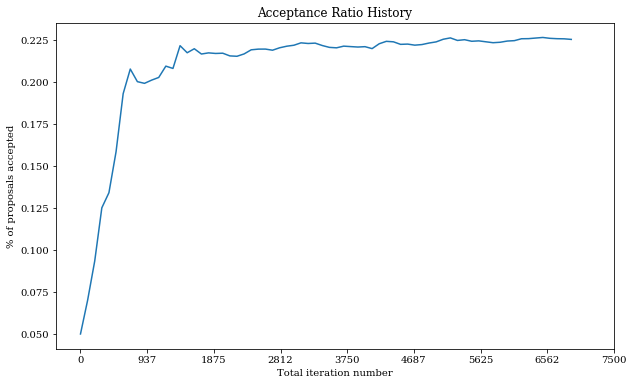

In [15]:
f = plt.figure(figsize=(10,6))

ax = f.add_subplot(111)
ax.plot(ratio_hist)
ax.set_title('Acceptance Ratio History')
ax.set_ylabel('% of proposals accepted')
ax.set_xlabel('Total iteration number')
ax.set_xticks(np.linspace(0,75,9))
ax.set_xticklabels(np.linspace(0,7500,9).astype(int))

plt.savefig('mcmc_log_acceptance_ratio.pdf', bbox_inches = 'tight');

In [0]:
# files.download('mcmc_log_acceptance_ratio.pdf')

In [0]:
# Looking at how the R hat changes every 100 iterations

r_hat_r_df = [set_of_trace[index]['r'] for index in set_of_trace]
r_hat_k_df = [set_of_trace[index]['K'] for index in set_of_trace]


In [0]:
r_hat_r = pd.DataFrame()
for i in range(5):
    r_hat_r[i] = r_hat_r_df[i]
    
r_hat_k = pd.DataFrame()
for i in range(5):
    r_hat_k[i] = r_hat_k_df[i]

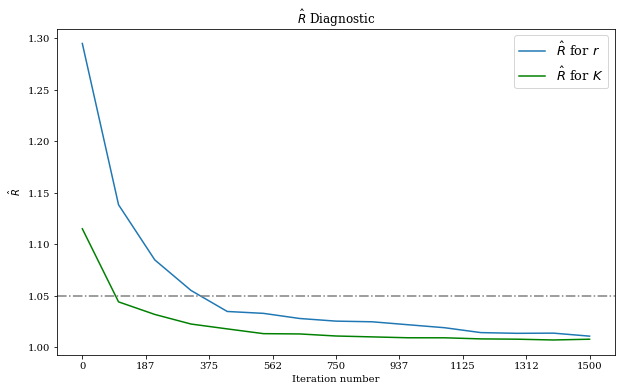

In [19]:
r_hat_hist_r = []
r_hat_hist_k = []
for i in range(15):
    r_hat_hist_r.append(R_hat(r_hat_r.iloc[:i*100 + 99]))
    r_hat_hist_k.append(R_hat(r_hat_k.iloc[:i*100 + 99]))
    

f = plt.figure(figsize=(10,6))

ax = f.add_subplot(111)
    
ax.plot(r_hat_hist_r)
ax.plot(r_hat_hist_k, color = 'g')
ax.axhline(y = 1.05, linestyle = '-.',  color = 'gray')
ax.set_title('$\hat{R}$ Diagnostic')
ax.set_ylabel('$\hat{R}$')
ax.set_xlabel('Iteration number')
ax.legend(['$\hat{R}$ for $r$','$\hat{R}$ for $K$'], prop={'size': 13})


ax.set_xticks(np.linspace(0,14,9))
ax.set_xticklabels(np.linspace(0,1500,9).astype(int))

plt.savefig('mcmc_log_r_hat.pdf', bbox_inches = 'tight')

In [0]:
# files.download('mcmc_log_r_hat.pdf')

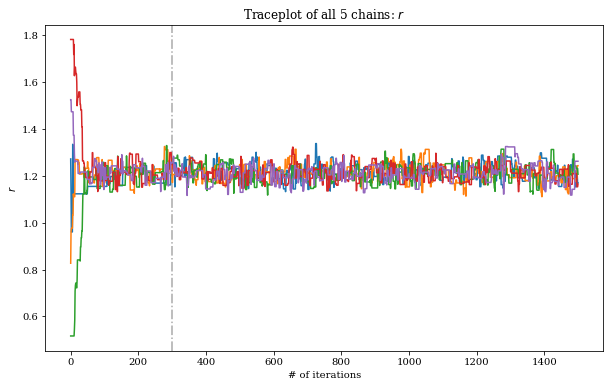

In [21]:
plt.axvline(300, color = 'darkgray', linestyle = '-.')
plt.plot(set_of_trace[0]['r'])
plt.plot(set_of_trace[1]['r'])
plt.plot(set_of_trace[2]['r'])
plt.plot(set_of_trace[3]['r'])
plt.plot(set_of_trace[4]['r'])
plt.title("Traceplot of all 5 chains: $r$")
plt.xlabel("# of iterations")
plt.ylabel("$r$")

plt.show()

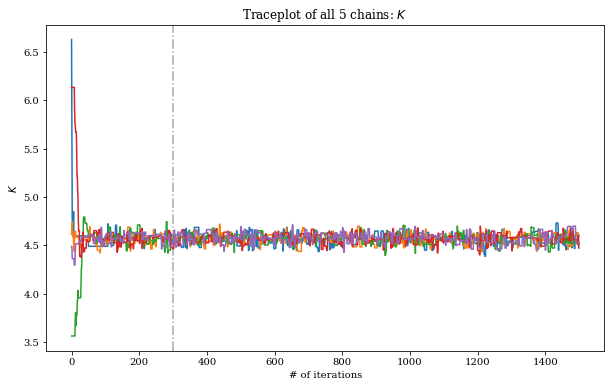

In [22]:
plt.axvline(300, color = 'darkgray', linestyle = '-.')
plt.plot(set_of_trace[0]['K'])
plt.plot(set_of_trace[1]['K'])
plt.plot(set_of_trace[2]['K'])
plt.plot(set_of_trace[3]['K'])
plt.plot(set_of_trace[4]['K'])
plt.title("Traceplot of all 5 chains: $K$")
plt.xlabel("# of iterations")
plt.ylabel("$K$")

plt.show()

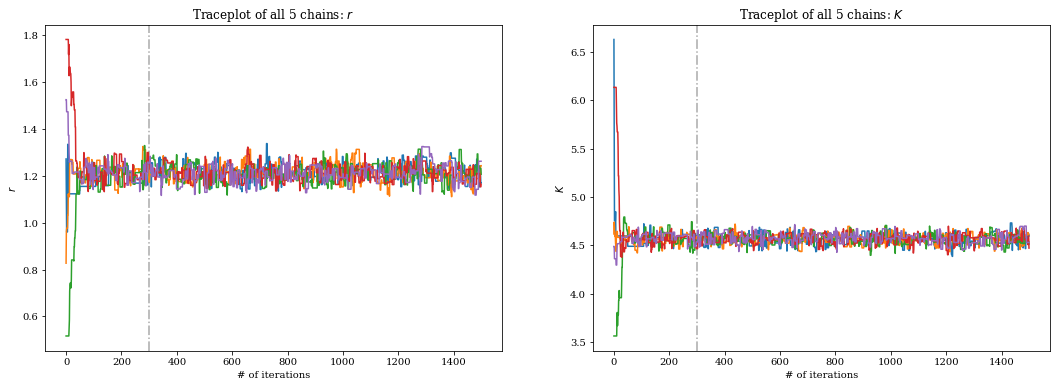

In [23]:
f = plt.figure(figsize=(18,6))

ax = f.add_subplot(121)
ax2 = f.add_subplot(122)

ax.axvline(300, color = 'darkgray', linestyle = '-.')
ax.plot(set_of_trace[0]['r'])
ax.plot(set_of_trace[1]['r'])
ax.plot(set_of_trace[2]['r'])
ax.plot(set_of_trace[3]['r'])
ax.plot(set_of_trace[4]['r'])
ax.set_title("Traceplot of all 5 chains: $r$")
ax.set_xlabel("# of iterations")
ax.set_ylabel("$r$")

ax2.axvline(300, color = 'darkgray', linestyle = '-.')
ax2.plot(set_of_trace[0]['K'])
ax2.plot(set_of_trace[1]['K'])
ax2.plot(set_of_trace[2]['K'])
ax2.plot(set_of_trace[3]['K'])
ax2.plot(set_of_trace[4]['K'])
ax2.set_title("Traceplot of all 5 chains: $K$")
ax2.set_xlabel("# of iterations")
ax2.set_ylabel("$K$")

plt.savefig('mcmc_log_join_traceplots.pdf', bbox_inches = 'tight')

In [0]:
# files.download('mcmc_log_join_traceplots.pdf')

## Posterior Distribution

Now we want to look at the posterior distribution having observed the data and look at our updated beliefs about the values of the parameters $\lambda$ and $K$.

In [0]:
from mpl_toolkits.mplot3d import Axes3D

In [0]:
# Dropping the first 300 samples as the burn in period.

full_trace = set_of_trace[0].loc[300:].append([set_of_trace[1].loc[300:], set_of_trace[2].loc[300:], set_of_trace[3].loc[300:], set_of_trace[4].loc[300:]])

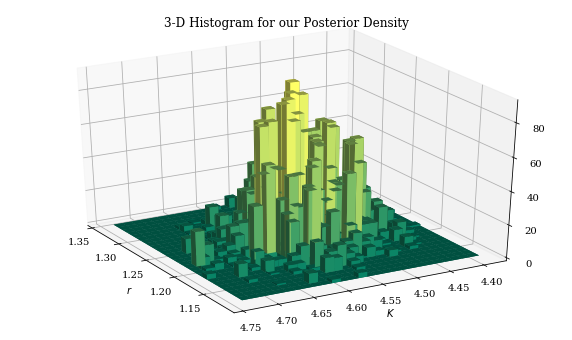

In [27]:
xAmplitudes = full_trace["r"]
yAmplitudes = full_trace["K"]

x = np.array(xAmplitudes, dtype = 'float64')   #turn x,y data into numpy arrays
y = np.array(yAmplitudes, dtype = 'float64')

fig = plt.figure()          #create a canvas, tell matplotlib it's 3d
ax = fig.add_subplot(111, projection='3d')

histo, xedges, yedges = np.histogram2d(x, y, bins=(27,27))
xpos, ypos = np.meshgrid(xedges[:-1]+xedges[1:], yedges[:-1]+yedges[1:])

xpos = xpos.flatten()/2.
ypos = ypos.flatten()/2.
zpos = np.zeros_like (xpos)

dx = xedges [1] - xedges [0]
dy = yedges [1] - yedges [0]
dz = histo.flatten()

cmap = plt.cm.get_cmap('summer') # Get desired colormap
max_height = np.max(dz)   # get range of colorbars so we can normalize
min_height = np.min(dz)
# scale each z to [0,1], and get their rgb values
rgba = [cmap((k-min_height)/max_height) for k in dz] 

ax.bar3d(xpos, ypos, zpos, dx, dy, dz, color=rgba, zsort='average')
plt.title("3-D Histogram for our Posterior Density")
plt.xlabel("$r$")
plt.ylabel("$K$")
ax.view_init(30, 150)

plt.show()

In [0]:
# 95% Credible Regions for each parameter

r_post = full_trace['r']
k_post = full_trace['K']

r_post = np.sort(r_post)
n = len(r_post)
low_q = int(np.round(0.025*n, 0))
upp_q = int(np.round(0.975*n, 0))

r_lower_bound = r_post[low_q]
r_upper_bound = r_post[upp_q]

k_post = np.sort(k_post)
n = len(k_post)
low_q = int(np.round(0.025*n, 0))
upp_q = int(np.round(0.975*n, 0))

k_lower_bound = k_post[low_q]
k_upper_bound = k_post[upp_q]

In [29]:
print("-----"*7)
print("---- Confidence Inteval for r ----")
print("         ["+ str(np.round(r_lower_bound, 3)) + ", " +str(np.round(r_upper_bound, 3)) + "]")
print("-----"*7)
print("-----"*7)
print("---- Confidence Inteval for K ----")
print("         ["+ str(np.round(k_lower_bound, 3))+ ", " +str(np.round(k_upper_bound, 3)) + "]")
print("-----"*7)

-----------------------------------
---- Confidence Inteval for r ----
         [1.145, 1.284]
-----------------------------------
-----------------------------------
---- Confidence Inteval for K ----
         [4.465, 4.669]
-----------------------------------


We can also look at the marginal posterior density as shown in the graph on the left. In addition to this we can also use Kernel Desnity Estimation to smooth our distribution as shown in the plot to the right.

## Kernel Density Estimation

In [0]:
kde_data = np.array([full_trace['r'].values, full_trace['K'].values])
kde_df = scipy.stats.gaussian_kde(kde_data, bw_method = 0.3)

In [0]:
r_grid = np.linspace(0.9, 1.5, 101)
k_grid = np.linspace(4.3, 4.9, 101)

grid = [[i, j] for i in r_grid for j in k_grid]

In [0]:
kde_matrix = np.zeros([101,101])
for i in range(101):
    for j in range(101):
        kde_matrix[i,101 - j - 1]= kde_df.pdf([r_grid[j], k_grid[i]])

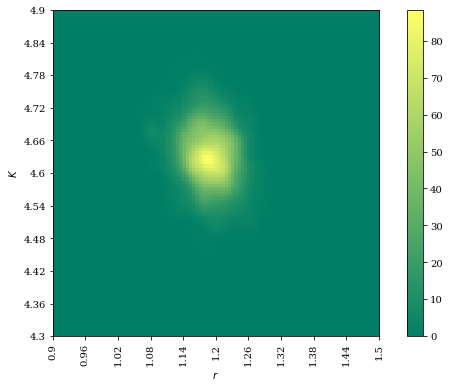

In [33]:


k_axis = []
for i in range(11):
    k_axis.append(np.round(k_grid[i*10], 2))
    
r_axis = []
for i in range(11):
    r_axis.append(np.round(r_grid[i*10],2))
    
k_axis.reverse()
    
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xticklabels(r_axis)
plt.xticks(range(len(r_axis)), rotation = 90)
ax.set_yticklabels(k_axis)
plt.yticks(range(len(k_axis)))
ax.xaxis.set_major_locator(plt.LinearLocator(11))
ax.yaxis.set_major_locator(plt.LinearLocator(11))

plt.xlabel('$r$')
plt.ylabel('$K$')

plt.imshow(kde_matrix, cmap = cm.summer)
plt.colorbar()
plt.show()

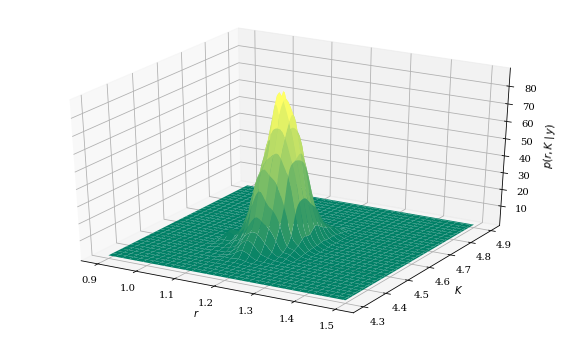

In [34]:


x, y = np.meshgrid(r_grid, k_grid)
fig = plt.figure()

ax = fig.gca(projection='3d')
surf = ax.plot_surface(x, y, kde_matrix, cmap=cm.summer,linewidth=0, antialiased=True)
ax.set_xlabel('$r$')
ax.set_ylabel('$K$')
ax.set_zlabel('$p(r, K \mid y)$')
plt.show()

In [0]:
kde_data_r = np.array([full_trace['r'].values])
kde_r = scipy.stats.gaussian_kde(kde_data_r, bw_method = 0.3)

kde_data_k = np.array([full_trace['K'].values])
kde_k = scipy.stats.gaussian_kde(kde_data_k, bw_method = 0.3)

kde_r_eval = kde_r.pdf(r_grid)
kde_k_grid = kde_k.pdf(k_grid)

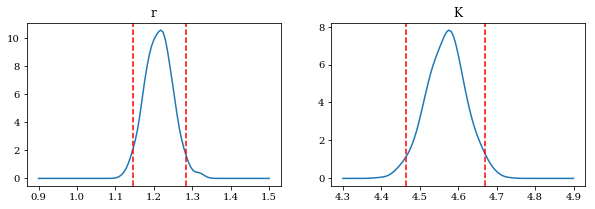

In [36]:
f = plt.figure(figsize=(10,3))

ax = f.add_subplot(121)
ax2 = f.add_subplot(122)

ax.plot(r_grid, kde_r_eval)
ax.set_title("r")
ax.axvline(r_lower_bound, linestyle = '--', color = 'r')
ax.axvline(r_upper_bound, linestyle = '--', color = 'r')

ax2.plot(k_grid, kde_k_grid)
ax2.set_title("K")
ax2.axvline(k_lower_bound, linestyle = '--', color = 'r')
ax2.axvline(k_upper_bound, linestyle = '--', color = 'r')


plt.show()

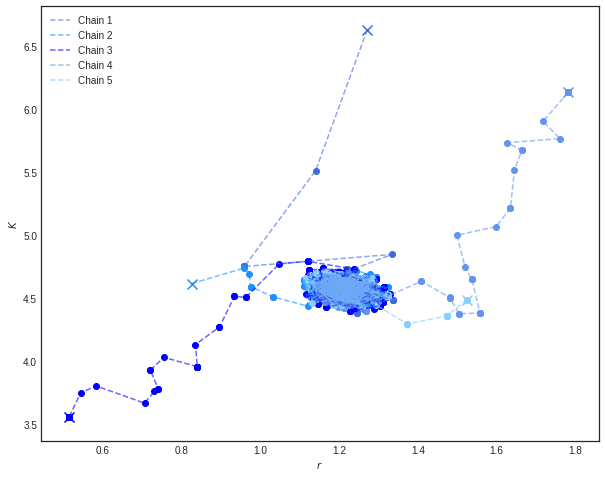

In [37]:
import matplotlib.style as style

plt.figure(figsize = (10,8))

style.use('seaborn-white')

plt.plot(set_of_trace[0]['r'], set_of_trace[0]['K'], '--', alpha = 0.6, color='royalblue')
plt.scatter(set_of_trace[0]['r'].iloc[0], set_of_trace[0]['K'].iloc[0], marker = 'x',  color='royalblue', s = 100)
plt.scatter(set_of_trace[0]['r'].iloc[1:], set_of_trace[0]['K'].iloc[1:],  color='royalblue')

plt.plot(set_of_trace[1]['r'], set_of_trace[1]['K'], '--', alpha = 0.6,  color='dodgerblue')
plt.scatter(set_of_trace[1]['r'].iloc[0], set_of_trace[1]['K'].iloc[0], marker = 'x',  color='dodgerblue', s = 100)
plt.scatter(set_of_trace[1]['r'].iloc[1:], set_of_trace[1]['K'].iloc[1:],  color='dodgerblue')

plt.plot(set_of_trace[2]['r'], set_of_trace[2]['K'], '--', alpha = 0.6,  color='blue')
plt.scatter(set_of_trace[2]['r'].iloc[0], set_of_trace[2]['K'].iloc[0], marker = 'x',  color='blue', s = 100)
plt.scatter(set_of_trace[2]['r'].iloc[1:], set_of_trace[2]['K'].iloc[1:],  color='blue')

plt.plot(set_of_trace[3]['r'], set_of_trace[3]['K'], '--', alpha = 0.6,  color='cornflowerblue')
plt.scatter(set_of_trace[3]['r'].iloc[0], set_of_trace[3]['K'].iloc[0], marker = 'x',  color='cornflowerblue', s = 100)
plt.scatter(set_of_trace[3]['r'].iloc[1:], set_of_trace[3]['K'].iloc[1:],  color='cornflowerblue')

plt.plot(set_of_trace[4]['r'], set_of_trace[4]['K'], '--', alpha = 0.6,  color='lightskyblue')
plt.scatter(set_of_trace[4]['r'].iloc[0], set_of_trace[4]['K'].iloc[0], marker = 'x',  color='lightskyblue', s = 100)
plt.scatter(set_of_trace[4]['r'].iloc[1:], set_of_trace[4]['K'].iloc[1:],  color='lightskyblue')

plt.legend(['Chain 1', 'Chain 2','Chain 3','Chain 4','Chain 5'], loc=2)
plt.xlabel('$r$')
plt.ylabel('$K$')
plt.savefig('mcmc_log_chain_movement_2.pdf', bbox_inches = 'tight')

In [0]:
files.download('mcmc_log_chain_movement_2.pdf')